In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn
import pickle

from utils_ridge import (
    GD, 
    RR_SVRG, 
    RR_VR,
    L_SVRG,
    SVRG,
    RR_SGD,
    SAGA_RR,
    SAGA
)
from ridge import optimal_rigde
np.random.seed(1)
random.seed(1)

In [2]:
def load_data(path, normalize = True):
    A, y = datasets.load_svmlight_file(path)
    A = A.toarray()
    if (normalize == True):
        A = sklearn.preprocessing.normalize(A, norm="l2")
    n = A.shape[0]
    d = A.shape[1]
    return A, y, n, d

def compute_constants(A, y, n, d, lambd):
    eigvals, _ = np.linalg.eigh(np.transpose(A)@A)
    eig_max = max(eigvals)
    eig_min = min(eigvals)
    L = eig_max/n+lambd
    L_i_list = []
    for i in range(n):
        L_i_list.append(np.linalg.norm(A[i,:])**2+lambd)
    mu = eig_min/n+lambd
    L_max = max(L_i_list)
    return L, mu, L_max, L_i_list

In [3]:
algo_func_pair = {
    "L-SVRG": L_SVRG,
    "RR": RR_SGD,
    "RR-SVRG": RR_SVRG,
    "SVRG": SVRG,
    "RR-SAGA": SAGA_RR,
    "SAGA": SAGA,
    "RR-VR.9": RR_VR,
    "RR-VR.5": RR_VR,
    "RR-VR.95": RR_VR,
    "RR-VR.8": RR_VR       
}

In [4]:
def main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE):
    A, y, n, d = load_data(DATASET_NAME+".txt", normalize = NORMALIZE)
    if (STR_LAMBDA == '1_n'):
        lambd = 1/n
    elif (STR_LAMBDA == '10_n'):
        lambd = 10/n
    elif (STR_LAMBDA == '1_10n'):
        lambd = 1/10/n
    L, mu, L_max, L_i_list = compute_constants(A, y, n, d, lambd)
    print("n = {}, d = {}, L = {:.5f}, L_max = {:.5f}, mu = {:.5f}, kappa = {:.5f}".format(n, d, L, L_max, mu, L_max/mu))
    x_star = optimal_rigde(A, y, lambd, n, d)
    return A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star

#### Experiment #2
Comparison of SAGA, SAGA-RR, RR-SVRG, L-SVRG, RR-VR0.5

Dataset: bodyfat, a1a

Algorithms: SAGA, SAGA_RR, RR_SVRG, L_SVRG, SVRG, RR-VR.5

In [5]:
def myMain(algo_name, A, y, lambd, n, d, stepsize, x_star, iter_num = 100):
    if (algo_name == "RR-VR.9"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.9, max_num_iter = iter_num)        
    if (algo_name == "RR-VR.8"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.8, max_num_iter = iter_num)
    if (algo_name == "RR-VR.5"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.5, max_num_iter = iter_num)    
    return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, max_num_iter = iter_num)

In [6]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "bodyfat"
NORMALIZE = True
STR_LAMBDA = '1_n'

In [7]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 252, d = 14, L = 0.99804, L_max = 1.00397, mu = 0.00397, kappa = 252.80584


In [8]:
stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [9]:
number_of_experiments = 1
number_of_epochs = 100
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_error[-1])
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA
0.010147256966201935
1.0019627230345032 SAGA
4.293290570838375e-27
0.5009813615172516 SAGA
4.363784084538129e-27
7.425151178567702e-19
5.120741725363893e-10
RR-SAGA
0.00940972021322278
1.0019627230345032 RR-SAGA
4.327090475107118e-27
0.5009813615172516 RR-SAGA
2.8378226320492315e-26
2.2110374939764304e-17
1.10132380089961e-09
RR-SVRG
8.030552078664702e-28
1.0019627230345032 RR-SVRG
8.348041585451542e-28
8.354501878981615e-28
7.617748685891326e-19
5.069189610568909e-10
L-SVRG
8.848197233797743e-28
1.0019627230345032 L-SVRG
8.155933982939974e-28
0.5009813615172516 L-SVRG
9.150569274512735e-28
8.56011783967439e-19
5.407080989256008e-10
RR-VR.5
8.790490281515205e-28
1.0019627230345032 RR-VR.5
7.83348105172263e-28
0.5009813615172516 RR-VR.5
8.822962366488834e-28
7.630935259119016e-19
5.071125645803461e-10
SVRG
9.370746656403007e-28
1.0019627230345032 SVRG
8.308446658786432e-28
0.5009813615172516 SVRG
9.144339514833293e-28
7.584848827748981e-19
5.078321866914412e-10


In [10]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


In [11]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        plt.semilogy(results[algo]['grad_comps'][0], error_best[algo], label = algo, marker='*')
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

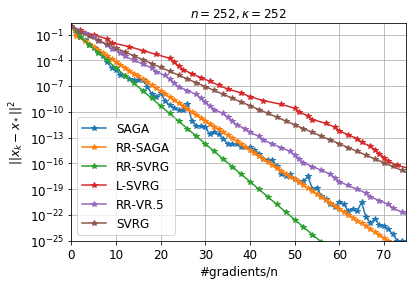

In [12]:
plot_results(results, xlim = 75, ylim = 1e-25)

In [13]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_rr_bodyfat_normalized_lambd_1_n


In [14]:
# plot_results(results, xlim = 75, ylim = 1e-25, filename=name+'.pdf', save=True)

In [15]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 2nd plot

In [16]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "bodyfat"
NORMALIZE = True
STR_LAMBDA = '10_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [17]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 252, d = 14, L = 1.03376, L_max = 1.03968, mu = 0.03969, kappa = 26.19799


In [18]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_error[-1])
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA
0.0017801531997923101
1.0019627230345032 SAGA
4.964764009411795e-19
0.5009813615172516 SAGA
2.9767941534569937e-22
0.3339875743448344 SAGA
1.475960040371696e-26
0.20039254460690067 SAGA
3.3944232559824206e-29
0.10019627230345034 SAGA
RR-SAGA
0.01821297575736698
1.0019627230345032 RR-SAGA
2.3092750514644293e-26
0.5009813615172516 RR-SAGA
3.4240350070800856e-29
0.3339875743448344 RR-SAGA
3.06534073161926e-29
0.20039254460690067 RR-SAGA
1.205601861862009e-27
RR-SVRG
1.4159237339223782e-30
1.0019627230345032 RR-SVRG
9.064942058598615e-31
0.5009813615172516 RR-SVRG
1.2023715743548813e-30
5.30894991249466e-31
0.20039254460690067 RR-SVRG
7.213405320794623e-30
L-SVRG
1.3427676015659395e-30
1.0019627230345032 L-SVRG
1.036869742246806e-30
0.5009813615172516 L-SVRG
7.909201787948106e-31
0.3339875743448344 L-SVRG
1.5054532172986102e-30
1.3869756493193825e-30
RR-VR.5
9.834271245181992e-31
1.0019627230345032 RR-VR.5
1.4830326419688393e-30
1.2563217659651017e-30
1.4144446745469234e-30
1.08625176

In [19]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


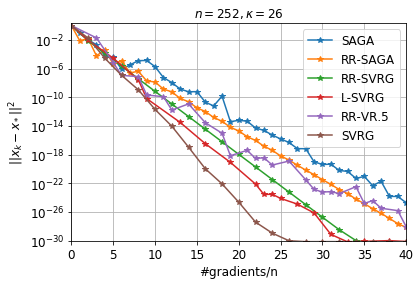

In [20]:
plot_results(results, xlim=40, ylim=1e-30)

In [21]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_rr_bodyfat_normalized_lambd_10_n


In [22]:
# plot_results(results, xlim=40, ylim=1e-30, filename=name+'.pdf', save=True)  

In [23]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 3rd plot

In [24]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "a1a"
NORMALIZE = True
STR_LAMBDA = '10_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [25]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 1605, d = 119, L = 0.45807, L_max = 1.00623, mu = 0.00623, kappa = 161.50000


In [26]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_error[-1])
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA
4.9066463102759175e-08
0.9673468141755708 SAGA
1.210985455319719e-18
0.4836734070877854 SAGA
2.233081692314608e-22
0.3224489380585236 SAGA
3.27445513276901e-25
0.19346936283511418 SAGA
1.142380824466347e-27
0.09673468141755709 SAGA
RR-SAGA
3.2531035225721527e-09
0.9673468141755708 RR-SAGA
1.8235477188815252e-29
0.4836734070877854 RR-SAGA
1.7101926524621184e-29
0.3224489380585236 RR-SAGA
4.157183783030292e-29
4.3319431109258175e-27
RR-SVRG
6.580562985167543e-20
0.9673468141755708 RR-SVRG
1.4852675845030382e-30
0.4836734070877854 RR-SVRG
1.61432091768626e-30
3.1108457020798652e-30
2.2683263197147877e-28
L-SVRG
4.900561566907127e-16
0.9673468141755708 L-SVRG
2.7285723669197458e-30
0.4836734070877854 L-SVRG
2.3987488430912853e-30
0.3224489380585236 L-SVRG
8.013944733464854e-30
7.499069652237369e-29
RR-VR.5
3.5988915594937455e-08
0.9673468141755708 RR-VR.5
5.611004672875202e-21
0.4836734070877854 RR-VR.5
6.5850550645513e-26
0.3224489380585236 RR-VR.5
1.0752979381160176e-29
0.1934693628

In [27]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


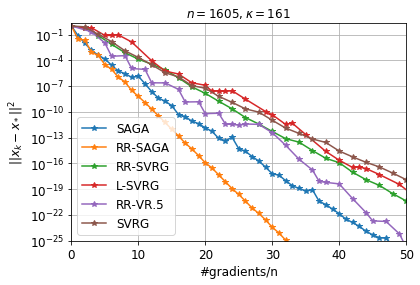

In [28]:
plot_results(results, xlim=50, ylim=1e-25)

In [29]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_rr_a1a_normalized_lambd_10_n


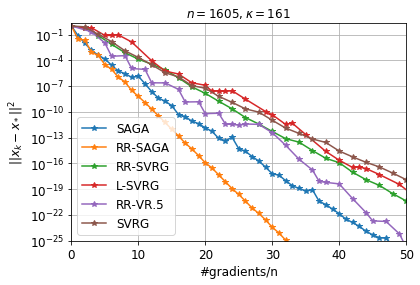

In [30]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
# plot_results(results, xlim=50, ylim=1e-25, filename=name+'.pdf', save=True)  

#### 4th plot

In [31]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "a1a"
NORMALIZE = True
STR_LAMBDA = '1_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [32]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 1605, d = 119, L = 0.45246, L_max = 1.00062, mu = 0.00062, kappa = 1606.00000


In [33]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_error[-1])
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA
inf
3454.6040493177966
1.0915363794388198 SAGA
8.14296426743394e-11
0.7276909196258798 SAGA
1.2957765564846508e-17
0.43661455177552794 SAGA
8.613923917408771e-11
RR-SAGA
3.1097172368749306e+261
1093.4448117620707
1.0915363794388198 RR-SAGA
2.3069117114976447e-13
0.7276909196258798 RR-SAGA
7.412756120751396e-17
0.43661455177552794 RR-SAGA
5.623683718918751e-10
RR-SVRG
7.723708850339241e+253
3.313708226973626e-08
1.0915363794388198 RR-SVRG
1.971049822047537e-23
0.7276909196258798 RR-SVRG
2.3595524516558695e-20
8.466020788773718e-11
L-SVRG
7.65847564392973e+247
8.173346959452775e-06
1.0915363794388198 L-SVRG
1.8832510646513426e-18
0.7276909196258798 L-SVRG
2.740251709309764e-20
0.43661455177552794 L-SVRG
8.342009626043894e-11
RR-VR.5
1.2672672899743539e+222
0.035677280753543816
1.0915363794388198 RR-VR.5
7.117611644053321e-12
0.7276909196258798 RR-VR.5
2.196874636538883e-19
0.43661455177552794 RR-VR.5
8.499958124373403e-11
SVRG
3.206978066547422e+254
2.9383006144909013e-07
1.09153637

In [34]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


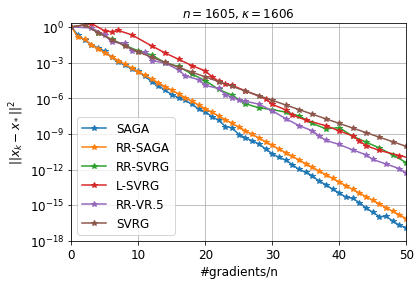

In [35]:
plot_results(results, xlim=50, ylim=1e-18)

In [36]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_rr_a1a_normalized_lambd_1_n


In [37]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
# plot_results(results, xlim=50, ylim=1e-18, filename=name+'.pdf', save=True)  